### 马尔可夫模型与n元语法

如果$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，则序列上的分布满足一阶马尔可夫性质。 阶数越高，对应的依赖关系就越长。 这种性质推导出了许多可以应用于序列建模的近似公式：

$\begin{split}\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}\end{split}$
 
通常，涉及一个、两个和三个变量的概率公式分别被称为 “一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）模型。

### 自然语言统计

In [ ]:
!pip install d2l
import random
import torch
from d2l import torch as d2l


In [ ]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

最流行的词看起来很无聊， 这些词通常被称为停用词（stop words），因此可以被过滤掉。 尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。 此外，还有个明显的问题是词频衰减的速度相当地快。 例如，最常用单词的词频对比，第$10$个还不到第$1$个的$1/5$。 为了更好地理解，我们可以画出的词频图：

In [ ]:
!pip install matplotlib==3.0.0

通过此图我们可以发现：词频以一种明确的方式迅速衰减。 将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。

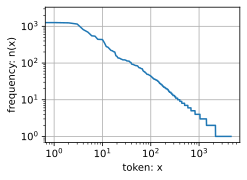

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。

In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])] # 从头开始将相邻的两个元素zip起来
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的， 只有一个与“the time”有关。 我们再进一步看看三元语法的频率是否表现出相同的行为方式。

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])] # 从头开始将相邻的三个元素zip起来
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，我们直观地对比三种模型中的词元频率：一元语法、二元语法和三元语法。

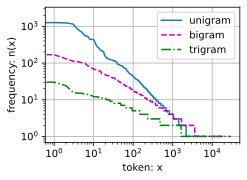

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

### 读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。当序列变得太长而不能被模型一次性全部处理时，我们可能希望拆分这样的序列方便模型读取。

在介绍该模型之前，我们看一下总体策略。 假设我们将使用神经网络来训练语言模型， 模型中的网络一次处理具有预定义长度（例如$n$个时间步）的一个小批量序列。 现在的问题是如何随机生成一个小批量数据的特征和标签以供读取。

首先，由于文本序列可以是任意长的， 例如整本《时光机器》（The Time Machine）， 于是任意长的序列可以被我们划分为具有相同时间步数的子序列。 当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。 假设网络一次只处理具有$n$个时间步的子序列。  下图画出了从原始文本序列获得子序列的所有不同的方式， 其中$n=5$，并且每个时间步的词元对应于一个字符。 请注意，因为我们可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度。



分割文本时，不同的偏移量会导致不同的子序列

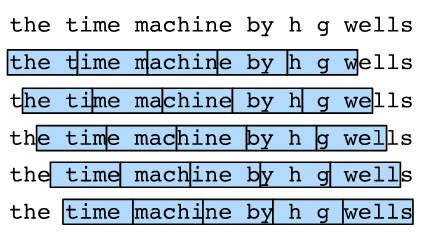

因此，我们应该从上图中选择哪一个呢？ 事实上，他们都一样的好。 然而，如果我们只选择一个偏移量， 那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。 因此，我们可以从随机偏移量开始划分序列， 以同时获得覆盖性（coverage）和随机性（randomness）。

### 随机采样

在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。 在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。 对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元， 因此标签是移位了一个词元的原始序列。

下面的代码每次可以从数据中随机生成一个小批量。 在这里，参数batch_size指定了每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps): 
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    print(corpus)
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    print(num_subseqs)
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    print(initial_indices)
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    print(random.shuffle(initial_indices))

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
6
[0, 5, 10, 15, 20, 25]
X:  tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]])
X:  tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])


### 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    print(offset)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    print(num_tokens)
    # 上述代码与随机采样类似
    # Xs和Ys固定数量为30
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    print(Xs)
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    print(Ys)
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    print(Xs,Ys)

    
    num_batches = Xs.shape[1] // num_steps
    print(num_batches)
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

4
30
tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])
tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]) tensor([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]])
3
X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器。

In [ ]:
class SeqDataLoader:  
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

定义了一个函数load_data_time_machine， 它同时返回数据迭代器和词表， 因此可以与其他带有load_data前缀的函数类似地使用。

In [ ]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab